In [21]:
import pandas as pd
import csv
from system import *
from analye_model import *
from plot_rooflines import *
from operators import RELU, ADD, GEMM, CONV2D
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Lab Layout 
Part 1 : Understanding various operators 
-  Writing number of operations for matmul, conv, relu, add - 2 point
-  Writing data movement for matmul, conv, relu, add   - 2 point

Part 2 : Runtime Computations - 2 points
- Compute time 
- Memory time 
- Roofline time 


Part 3 : Building Neural Networks  - 2 point
- Alexnet
- Bert


Part 4 : Comparing the performance of NN on different HWs - 2 points



## A.1 Various operators

In [23]:
## Only run this once you have completed code in operators.py
relu1 = RELU([2, 256])
relu2 = RELU([254, 5])

add1 = ADD([2, 8, 512])
add2 = ADD([8, 128, 1024])

gemm1 = GEMM([32, 8, 16, 32])
gemm2 = GEMM([2, 128, 128, 128])

conv1 = CONV2D([3, 256, 96, 128, 128 , 5, 5])
conv2 = CONV2D([1, 256, 384, 12, 12 , 3, 3])

with open('output_a1.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['relu1', list(relu1.get_tensors()), relu1.get_num_ops()])
    writer.writerow(['relu2', list(relu2.get_tensors()), relu2.get_num_ops()])
    writer.writerow(['add1',  list(add1.get_tensors()), add1.get_num_ops()])
    writer.writerow(['add2',  list(add2.get_tensors()), add2.get_num_ops()])
    writer.writerow(['gemm1', list(gemm1.get_tensors()), gemm1.get_num_ops()])
    writer.writerow(['gemm2', list(gemm2.get_tensors()), gemm2.get_num_ops()])
    writer.writerow(['conv1', list(conv1.get_tensors()), conv1.get_num_ops()])
    writer.writerow(['conv2', list(conv2.get_tensors()), conv2.get_num_ops()])

## A.2 Runtime Computations.

In [24]:
example_network = [relu1, relu2, add1, add2, gemm1, gemm2, conv1, conv2]

In [25]:
## A100 https://www.nvidia.com/content/dam/en-zz/Solutions/Data-Center/a100/pdf/nvidia-a100-datasheet-us-nvidia-1758950-r4-web.pdf
A100_GPU = System( offchip_mem_bw=1935,
                   flops=312, frequency=1095 ,
                   compute_efficiency=0.75, memory_efficiency=0.7)
## https://developer.nvidia.com/embedded/jetson-modules
jetson_nano = System( offchip_mem_bw=34, 
                 flops=20, frequency=625, 
                 compute_efficiency=0.85, memory_efficiency=0.75  )

In [26]:
model_df = analysis_model(example_network, A100_GPU)

model_df.to_csv('output_a2.csv', index=False)

512  9.857098877583979e-10    519422607360.00006   thpt
1270  2.4450225731507136e-09    519422607360.0   thpt
8192  2.365703730620155e-08    346281738240.0   thpt
1048576  3.0281007751937984e-06    346281738240.0   thpt
8388608  5.377312820512821e-08    156000000000000.0   thpt
1073741824  6.882960410256411e-06    156000000000000.0   thpt
60397977600  0.00038716652307692307    156000000000000.0   thpt
254803968  1.6333587692307692e-06    156000000000000.0   thpt


## A.3 Building Neural Networks

### TODO A.3.i : Alexnet

In [27]:
## For reference only.
batch_size = 2000
example_network = [ RELU([batch_size, 128]),
            ADD([batch_size, 8, 1026]),
            GEMM([batch_size, 8, 16, 32]),
            ]

In [28]:
def alexnet(batch_size):
    ## Fill in the opertors of alexnet, please refer to the figure in pdf document.
    ## Refer the example_network to follow the network declaration
    model_arch = [         
        #B, K, C, X, Y, R, S
                    CONV2D([batch_size, 96,3,224,224,11,11]),
                    RELU([batch_size, 96*54*54]),
                    CONV2D([batch_size, 256,96,54,54,5,5]),
                    RELU([batch_size, 256*26*26]),
                    CONV2D([batch_size, 384,256,26,26,3,3]),
                    RELU([batch_size, 384*12*12]),
                    CONV2D([batch_size, 384,384,12,12,3,3]),
                    RELU([batch_size, 384*12*12]),
                    CONV2D([batch_size, 256,384,12,12,3,3]),
                    RELU([batch_size, 256*12*12]),
        #B, M, N, K
                    GEMM([batch_size,1,4096,6400]),
                    GEMM([batch_size,1,4096,4096]),
                    GEMM([batch_size,1,1000,4096]),
                 ]
    return model_arch

### TODO A.3.ii : Bert

In [19]:
def bert(batch_size):
    ## Fill in the opertors of bert, please refer to the figure in pdf document.
    ## Refer the example_network to follow the network declaration
    model_arch = [
        #B, M, N, K
        GEMM([batch_size,256,2304,768]),
        GEMM([batch_size,256,256,768]),
        GEMM([batch_size,256,768,256]),
        GEMM([batch_size,256,768,768]),
        #B, X, Y
        ADD([batch_size,256,768]),
        GEMM([batch_size,256,3072,768]),
        RELU([batch_size,256*3072 ]),
        GEMM([batch_size,256,768,3072]),
        ADD([batch_size,256,768]),
    ]
    return model_arch

### Running the networks

895249022976  0.005738775788307692    156000000000000.0   thpt
71663616  0.00013796784156976745    519422607360.0   thpt
917294284800  0.005880091569230769    156000000000000.0   thpt
44302336  8.529150516795866e-05    519422607360.0   thpt
306217746432  0.001962934272    156000000000000.0   thpt
14155776  2.7252906976744186e-05    519422607360.0   thpt
97844723712  0.0006272097673846154    156000000000000.0   thpt
14155776  2.7252906976744186e-05    519422607360.0   thpt
65229815808  0.0004181398449230769    156000000000000.0   thpt
9437184  1.816860465116279e-05    519422607360.0   thpt
85899345920000  0.5506368328205128    156000000000000.0   thpt
35184372088832  0.22554084672328206    156000000000000.0   thpt
8589934592000  0.05506368328205128    156000000000000.0   thpt


,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,CONV2D,"[256, 96, 3, 224, 224, 11, 11]",C,60.14,9031.49,5.74,6283959.49,895249.02,36.75,0.03,57.75,94.53,156.00,6283959.49,104483.50
1,RELU,"[256, 279936]",M,0.00,0.50,0.14,151074.79,71.66,68.34,0.00,68.34,136.69,0.52,503.02,151074.79
2,CONV2D,"[256, 256, 96, 54, 54, 5, 5]",C,67.89,10195.25,5.88,6438700.27,917294.28,68.34,0.59,16.88,85.80,156.00,6438700.27,94836.21
3,RELU,"[256, 173056]",M,0.00,0.50,0.09,93394.20,44.30,42.25,0.00,42.25,84.50,0.52,310.97,93394.20
4,CONV2D,"[256, 384, 256, 26, 26, 3, 3]",C,38.58,5793.57,1.96,2149413.03,306217.75,42.25,0.84,7.31,50.41,156.00,2149413.03,55711.85
5,RELU,"[256, 55296]",M,0.00,0.50,0.03,29841.93,14.16,13.50,0.00,13.50,27.00,0.52,99.36,29841.93
6,CONV2D,"[256, 384, 384, 12, 12, 3, 3]",C,34.25,5143.81,0.63,686794.70,97844.72,13.50,1.27,3.38,18.14,156.00,686794.70,20050.05
7,RELU,"[256, 55296]",M,0.00,0.50,0.03,29841.93,14.16,13.50,0.00,13.50,27.00,0.52,99.36,29841.93
8,CONV2D,"[256, 256, 384, 12, 12, 3, 3]",C,24.96,3748.88,0.42,457863.13,65229.82,13.50,0.84,2.25,16.59,156.00,457863.13,18340.35
9,RELU,"[256, 36864]",M,0.00,0.50,0.02,19894.62,9.44,9.00,0.00,9.00,18.00,0.52,66.24,19894.62


31892816.27221747   150.16674071319343   156.0 yqk
[0.00000000e+00 1.50166741e+02 3.18928163e+07]   [  0. 156. 156.] yqk2
Total Cycles:926550070.38, Total data (MB): 564.49


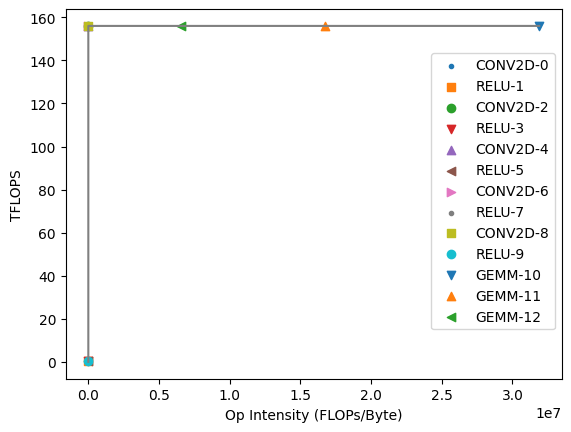

In [29]:

alexnet_on_a100_df = analysis_model(alexnet(256), A100_GPU)
display(alexnet_on_a100_df)

dot_roofline(alexnet_on_a100_df, A100_GPU)
print(f'Total Cycles:{sum(alexnet_on_a100_df.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(alexnet_on_a100_df.loc[:, "Total Data (MB)"]):0.2f}')

178120883699712  1.1418005365366153    156000000000000.0   thpt
19791209299968  0.12686672628184614    156000000000000.0   thpt
6597069766656  0.04228890876061538    156000000000000.0   thpt
59373627899904  0.3806001788455385    156000000000000.0   thpt
50331648  0.008035714285714285    6263493973.333334   thpt
237494511599616  1.522400715382154    156000000000000.0   thpt
201326592  0.02142857142857143    9395240960.0   thpt
949978046398464  6.089602861528616    156000000000000.0   thpt
50331648  0.008035714285714285    6263493973.333334   thpt


,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[256, 256, 2304, 768]",C,106.46,883872.84,1141.80,1250271587.51,178120883.70,48.00,0.19,144.00,192.19,156.00,1250271587.51,11743600.03
1,GEMM,"[256, 256, 256, 768]",C,35.42,294050.52,126.87,138919065.28,19791209.30,48.00,0.19,16.00,64.19,156.00,138919065.28,3922171.46
2,GEMM,"[256, 256, 768, 256]",C,11.83,98208.09,42.29,46306355.09,6597069.77,16.00,0.06,48.00,64.06,156.00,46306355.09,3914533.34
3,GEMM,"[256, 256, 768, 768]",C,70.91,588674.25,380.60,416757195.84,59373627.90,48.00,0.19,48.00,96.19,156.00,416757195.84,5877528.60
4,ADD,"[256, 256, 768]",M,0.00,0.33,8.04,8799107.14,50.33,48.00,48.00,48.00,144.00,0.01,353.29,8799107.14
5,GEMM,"[256, 256, 3072, 768]",C,113.58,942981.70,1522.40,1667028783.34,237494511.60,48.00,0.19,192.00,240.19,156.00,1667028783.34,14676635.74
6,RELU,"[256, 786432]",M,0.00,0.50,21.43,23464285.71,201.33,192.00,0.00,192.00,384.00,0.01,1413.16,23464285.71
7,GEMM,"[256, 256, 768, 3072]",C,453.27,3763113.87,6089.60,6668115133.37,949978046.40,192.00,0.75,48.00,240.75,156.00,6668115133.37,14711007.25
8,ADD,"[256, 256, 768]",M,0.00,0.33,8.04,8799107.14,50.33,48.00,48.00,48.00,144.00,0.01,353.29,8799107.14


3763113.8691588785   8302.075522286552   156.0 yqk
[      0.            8302.07552229 3763113.86915888]   [  0. 156. 156.] yqk2
Total Cycles:10228460620.43, Total data (MB): 1569.56


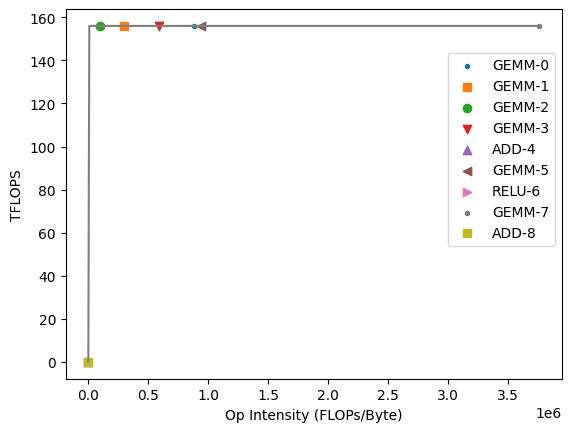

In [12]:
bert_on_a100_df = analysis_model(bert(256), A100_GPU)
display(bert_on_a100_df)

dot_roofline(bert_on_a100_df, A100_GPU)
print(f'Total Cycles:{sum(bert_on_a100_df.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(bert_on_a100_df.loc[:, "Total Data (MB)"]):0.2f}')

In [12]:
alexnet_on_a100_df.to_csv('output_a3i.csv', index=False)
bert_on_a100_df.to_csv('output_a3ii.csv', index=False)

## A.4 Compare on different Hardwares

### TODO A.4.i
Generate csv for alexnet and bert on jetson nano system, with batch size 4. <br>
Make sure to name the csv file 'output_a4i.csv' and 'output_a4ii.csv'

### TODO A.4.ii

Comment on the change in operator behavior between systems? Do they change, if so why?

### TODO A.4.iii

For running alexnet, what changes would you suggest to on hardware specs that would help in optimizing the performance?